# Analysis on Boston crime, Airbnb listings, and asymmetric information - Does the number of Major Crime occurrences have practical importance in determining the rental price of Airbnb Listings?

## Key Objectives

I. What types of major crimes are occuring and where they are occuring?

II. Can a large percentage of variation of Airbnb rental prices be predicted with available listing charcteristics?

III. Does major crime frequency associated with each listing (within a ~5km radius) in the last year have practical significance on improving the percentage of variation of Airbnb rental prices explained by factors available?

## Table of Contents

I. [What type of and where crimes are occuring](#What-Where)<br>
II. [Percentage of variation of rental prices Part I](#PartI)<br>
III. [Percentage of variation of rental prices Part II](#PartII)<br>

## Importing and downloading libraries

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import xgboost as xgb
from xgboost import plot_importance
from wordcloud import WordCloud,ImageColorGenerator
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import Imputer, StandardScaler, MinMaxScaler
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import zipfile
with zipfile.ZipFile("crimes-in-boston.zip", 'r') as zip_ref:
        zip_ref.extractall()
        
%config IPCompletor.greedy = True

In [86]:
crime_df = pd.read_excel('crime.xlsx')

In [87]:
crime_df.head(50)

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,I182070945,619,Larceny,LARCENY ALL OTHERS,D14,808,NaN,2018-09-02 13:00:00,2018,9,Sunday,13,Part One,LINCOLN ST,42.357791,-71.139371,"(42.35779134, -71.13937053)"
1,I182070943,1402,Vandalism,VANDALISM,C11,347,NaN,2018-08-21 00:00:00,2018,8,Tuesday,0,Part Two,HECLA ST,42.306821,-71.060300,"(42.30682138, -71.06030035)"
2,I182070941,3410,Towed,TOWED MOTOR VEHICLE,D4,151,NaN,2018-09-03 19:27:00,2018,9,Monday,19,Part Three,CAZENOVE ST,42.346589,-71.072429,"(42.34658879, -71.07242943)"
3,I182070940,3114,Investigate Property,INVESTIGATE PROPERTY,D4,272,NaN,2018-09-03 21:16:00,2018,9,Monday,21,Part Three,NEWCOMB ST,42.334182,-71.078664,"(42.33418175, -71.07866441)"
4,I182070938,3114,Investigate Property,INVESTIGATE PROPERTY,B3,421,NaN,2018-09-03 21:05:00,2018,9,Monday,21,Part Three,DELHI ST,42.275365,-71.090361,"(42.27536542, -71.09036101)"
5,I182070936,3820,Motor Vehicle Accident Response,M/V ACCIDENT INVOLVING PEDESTRIAN - INJURY,C11,398,NaN,2018-09-03 21:09:00,2018,9,Monday,21,Part Three,TALBOT AVE,42.290196,-71.071590,"(42.29019621, -71.07159012)"
6,I182070933,724,Auto Theft,AUTO THEFT,B2,330,NaN,2018-09-03 21:25:00,2018,9,Monday,21,Part One,NORMANDY ST,42.306072,-71.082733,"(42.30607218, -71.08273260)"
7,I182070932,3301,Verbal Disputes,VERBAL DISPUTE,B2,584,NaN,2018-09-03 20:39:37,2018,9,Monday,20,Part Three,LAWN ST,42.327016,-71.105551,"(42.32701648, -71.10555088)"
8,I182070931,301,Robbery,ROBBERY - STREET,C6,177,NaN,2018-09-03 20:48:00,2018,9,Monday,20,Part One,MASSACHUSETTS AVE,42.331521,-71.070853,"(42.33152148, -71.07085307)"
9,I182070929,3301,Verbal Disputes,VERBAL DISPUTE,C11,364,NaN,2018-09-03 20:38:00,2018,9,Monday,20,Part Three,LESLIE ST,42.295147,-71.058608,"(42.29514664, -71.05860832)"


In [88]:
print("The number of rows in the dataset is: {}".format(crime_df.shape[0]))
print("The number of columns in the dataset is: {}".format(crime_df.shape[1]))

The number of rows in the dataset is: 319073
The number of columns in the dataset is: 17


In [89]:
crime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319073 entries, 0 to 319072
Data columns (total 17 columns):
INCIDENT_NUMBER        319073 non-null object
OFFENSE_CODE           319073 non-null int64
OFFENSE_CODE_GROUP     319073 non-null object
OFFENSE_DESCRIPTION    319073 non-null object
DISTRICT               317308 non-null object
REPORTING_AREA         319073 non-null object
SHOOTING               1019 non-null object
OCCURRED_ON_DATE       319073 non-null datetime64[ns]
YEAR                   319073 non-null int64
MONTH                  319073 non-null int64
DAY_OF_WEEK            319073 non-null object
HOUR                   319073 non-null int64
UCR_PART               318983 non-null object
STREET                 308202 non-null object
Lat                    299074 non-null float64
Long                   299074 non-null float64
Location               319073 non-null object
dtypes: datetime64[ns](1), float64(2), int64(4), object(10)
memory usage: 41.4+ MB


## Clean Data

In [90]:
def clean_df(df=crime_df):
    '''
    INPUT
    df - pandas data frame that will be cleaned
    
    OUTPUT
    df_clean - cleaned data framed
    '''
    #Converting and filling datapoints so quantitative function would work
    df['INCIDENT_NUMBER'] = df['INCIDENT_NUMBER'].str.replace('I','')
    df['UCR_PART'] = df['UCR_PART'].str.replace('Part ', '')
    df['SHOOTING'] = df['SHOOTING'].fillna(0)
    df['SHOOTING'] = df['SHOOTING'].replace('Y', '1')
    
    #Sort values based on occurrence date
    df.sort_values(by = ['OCCURRED_ON_DATE'], ascending = False)
    
    #Drop records that have same incident numbers and offense code as they should not occur
    df1_clean = df.drop_duplicates(['INCIDENT_NUMBER', 'OFFENSE_CODE'])
    
    #Keep records that don't have unambigious locations
    df1_clean = df1_clean[(df1_clean['Long'] != -1) & (df1_clean['Lat'] != -1)]
    df1_clean = df1_clean[(df1_clean['Long'].notnull()) & (df1_clean['Lat'].notnull())]
    
    #Keep records with severe incidences
    df1_clean = df1_clean[df1_clean['UCR_PART'].isin(['One'])]
    
    #Change format of date variable
    df1_clean['OCCURRED_ON_DATE'] = pd.to_datetime(df1_clean['OCCURRED_ON_DATE'], format='%Y-%m-%d')
    
    return df1_clean
    
Crime_Clean_df = clean_df()

In [8]:
Crime_Clean_df['OFFENSE_CODE_GROUP'].value_counts()

Larceny                       25100
Larceny From Motor Vehicle    10285
Aggravated Assault             7267
Residential Burglary           5574
Auto Theft                     4528
Robbery                        4228
Commercial Burglary            1326
Other Burglary                  448
Homicide                        152
Arson                            91
Name: OFFENSE_CODE_GROUP, dtype: int64

In [9]:
Crime_Clean_df.describe()

,OFFENSE_CODE,YEAR,MONTH,HOUR,Lat,Long
count,58999.000000,58999.000000,58999.000000,58999.000000,58999.000000,58999.000000
mean,565.752555,2016.479245,6.770081,13.395786,42.327367,-71.082140
std,107.259101,1.017778,3.258026,6.303010,0.030268,0.028348
min,111.000000,2015.000000,1.000000,0.000000,42.232870,-71.178674
25%,521.000000,2016.000000,4.000000,9.000000,42.306493,-71.096108
50%,614.000000,2016.000000,7.000000,14.000000,42.333641,-71.077639
75%,617.000000,2017.000000,9.000000,18.000000,42.350412,-71.062469
max,900.000000,2018.000000,12.000000,23.000000,42.395042,-70.996038


In [10]:
Crime_Clean_df['DISTRICT'].value_counts()

D4     11832
B2      8399
A1      7966
C11     6551
B3      4864
C6      4192
D14     3857
E13     3477
E18     2552
A7      2157
E5      1842
A15     1214
Name: DISTRICT, dtype: int64

In [11]:
Crime_Clean_df.isnull().mean()

INCIDENT_NUMBER        0.000000
OFFENSE_CODE           0.000000
OFFENSE_CODE_GROUP     0.000000
OFFENSE_DESCRIPTION    0.000000
DISTRICT               0.001627
REPORTING_AREA         0.000000
SHOOTING               0.000000
OCCURRED_ON_DATE       0.000000
YEAR                   0.000000
MONTH                  0.000000
DAY_OF_WEEK            0.000000
HOUR                   0.000000
UCR_PART               0.000000
STREET                 0.003288
Lat                    0.000000
Long                   0.000000
Location               0.000000
dtype: float64

In [12]:
def subset_df(df, OCCURRED_ON_DATE_START, OCCURRED_ON_DATE_END, UCR_PART = ['One', 'Two'] ):
    
    '''
    INPUT
    df - Pandas dataframe in which a subsetted data frame is created based on
    OCCURRED_ON_DATE_START - Date indicating the start of the time period in which crimes are pulled
    OCCURRED_ON_DATE_END - Date indicating the end of the time period in which crimes are pulled
    OFFENSE_CODE_GROUP - String indicating the offense group
    
    OUTPUT
    subset_df - A subsetted date frame
    '''
    #Filter data for the UCR type and date period of interest
    subset_df = df[(df['UCR_PART'].isin(UCR_PART)) 
                   & (df['OCCURRED_ON_DATE'] >= OCCURRED_ON_DATE_START)
                   & (df['OCCURRED_ON_DATE'] <= OCCURRED_ON_DATE_END)]
    
    return subset_df

In [13]:
def clean_and_plot_crime(df, Column, n = Crime_Clean_df.shape[0], plot = True):
    
    '''
    INPUT
    df - pandas dataframe in which crimes by district plot and dataframe is based on
    plot - binary variable to determine whether or not a plot is created
    
    OUTPUT
    Cleaned pandas dataframe and plot of crimes by district
    '''
    
    new = df[Column].value_counts().reset_index()
    new.rename(columns = {'index': "{}".format(Column), '{}'.format(Column): "% of Crimes"}, inplace = True)
    new_df = pd.DataFrame(new)
    new_df.set_index('{}'.format(Column), inplace = True)
    
    if plot:
        (new_df/df.shape[0])[:n].plot(kind= 'bar', legend = False)
        plt.xlabel("{}".format(Column))
        plt.ylabel("Number of Crimes")
        plt.title("Crimes by {}".format(Column))
        plt.show()
    
    return (new_df/df.shape[0])[:n]


### <a class="anchor" id="What-Where">Objective I : What types of major crimes are occuring and where are they occuring</a>

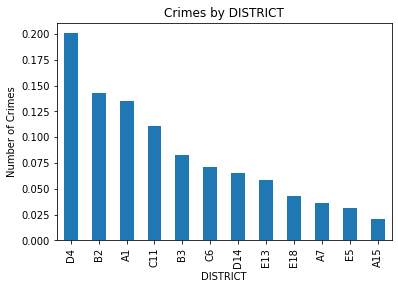

,% of Crimes
DISTRICT,
D4,0.200546
B2,0.142358
A1,0.135019
C11,0.111036
B3,0.082442
C6,0.071052
D14,0.065374
E13,0.058933
E18,0.043255


In [271]:
Crime_by_District = clean_and_plot_crime(Crime_Clean_df, 'DISTRICT')
Crime_by_District

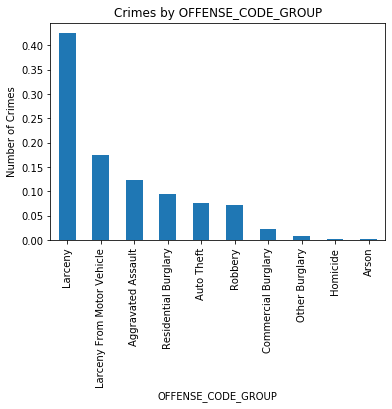

,% of Crimes
OFFENSE_CODE_GROUP,
Larceny,0.425431
Larceny From Motor Vehicle,0.174325
Aggravated Assault,0.123172
Residential Burglary,0.094476
Auto Theft,0.076747
Robbery,0.071662
Commercial Burglary,0.022475
Other Burglary,0.007593
Homicide,0.002576


In [272]:
Crime_by_Offense_Group = clean_and_plot_crime(Crime_Clean_df, 'OFFENSE_CODE_GROUP', 10)
Crime_by_Offense_Group

In [273]:
Crime_Clean_df.groupby(['DISTRICT','OFFENSE_CODE_GROUP']).agg({'INCIDENT_NUMBER': 'count'})\
.sort_values(by= ['INCIDENT_NUMBER'], ascending = [False])[:10]

INCIDENT_NUMBER
DISTRICT OFFENSE_CODE_GROUP                         
D4       Larceny                                7147
A1       Larceny                                4488
B2       Larceny                                2789
C11      Larceny                                2139
D4       Larceny From Motor Vehicle             1837
C6       Larceny                                1731
D14      Larceny                                1600
B2       Aggravated Assault                     1544
         Larceny From Motor Vehicle             1393
A1       Larceny From Motor Vehicle             1249

### Findings:
Based on the data, most of the crimes are happening in Districts D4, B2, and A1, and a large portion of the crimes are in the Larceny offense group.

### <a class="anchor" id="PartI">Objective II : Variations of Boston AirBnb rental prices part I</a>

In [274]:
df_AirBnB_listing = pd.read_csv("listings.csv")
df_AirBnB_listing.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,10.0,f,NaN,NaN,f,flexible,f,f,1,2.25


In [275]:
df_AirBnB_listing.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

In [276]:
df_AirBnB_listing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
id                                  3585 non-null int64
listing_url                         3585 non-null object
scrape_id                           3585 non-null int64
last_scraped                        3585 non-null object
name                                3585 non-null object
summary                             3442 non-null object
space                               2528 non-null object
description                         3585 non-null object
experiences_offered                 3585 non-null object
neighborhood_overview               2170 non-null object
notes                               1610 non-null object
transit                             2295 non-null object
access                              2096 non-null object
interaction                         2031 non-null object
house_rules                         2393 non-null object
thumbnail_url                       2986

In [277]:
def clean_airbnb_listing_data(df = df_AirBnB_listing):
    '''
    INPUT
    df - pandas data frame that will be cleaned
    
    OUPUT
    new_df - cleaned pandas data frame
    '''
    
    new_df = df[['id', 'last_scraped', 'host_is_superhost', 'host_total_listings_count',
                             'host_identity_verified', 'property_type', 'neighbourhood_cleansed',
                            'room_type', 'bedrooms', 'price', 'review_scores_rating', 
                            'number_of_reviews', 'latitude', 'longitude']]
    
    
    #Keep only listing with bedrooms and reviews
    new_df = new_df[(new_df['bedrooms'].notnull()) & (new_df['review_scores_rating'].notnull()) 
                    & (new_df['number_of_reviews'] >= 10)]
    
    #Change price into a float so it can be used in regression analysis
    new_df['price'] = new_df['price'].str.replace('$','').astype(float)
    
    return new_df



In [278]:
Subset_AirBnB_listing_df = clean_airbnb_listing_data()
Subset_AirBnB_listing_df.head()

,id,last_scraped,host_is_superhost,host_total_listings_count,host_identity_verified,property_type,neighbourhood_cleansed,room_type,bedrooms,price,review_scores_rating,number_of_reviews,latitude,longitude
1,3075044,2016-09-07,f,1,t,Apartment,Roslindale,Private room,1.0,65.0,94.0,36,42.286241,-71.134374
2,6976,2016-09-07,t,1,t,Apartment,Roslindale,Private room,1.0,65.0,98.0,41,42.292438,-71.135765
4,7651065,2016-09-07,t,1,t,House,Roslindale,Private room,1.0,79.0,99.0,29,42.284512,-71.136258
6,5706985,2016-09-07,f,5,t,Apartment,Roslindale,Entire home/apt,1.0,100.0,90.0,57,42.281390,-71.131190
7,2843445,2016-09-07,t,2,t,House,Roslindale,Private room,1.0,75.0,96.0,67,42.281946,-71.141022


In [279]:
Subset_AirBnB_listing_df.shape

(1409, 14)

In [280]:
Subset_AirBnB_listing_df['host_is_superhost'].value_counts()

f    1080
t     329
Name: host_is_superhost, dtype: int64

In [281]:
def create_binary_col(host_obj):
    '''
    INPUT
    host_obj - a binary object
    
    OUTPUT
    return 0 if f
    return 1 if t
    '''
    #Change binary representation so that it can be used for regression analysis
    if host_obj == 'f':
        return 0
    else:
        return 1



In [282]:
Subset_AirBnB_listing_df['host_is_superhost'] = Subset_AirBnB_listing_df['host_is_superhost'].apply(create_binary_col)
Subset_AirBnB_listing_df['host_identity_verified'] = Subset_AirBnB_listing_df['host_identity_verified'].apply(create_binary_col)

In [283]:
Subset_AirBnB_listing_df.head()

,id,last_scraped,host_is_superhost,host_total_listings_count,host_identity_verified,property_type,neighbourhood_cleansed,room_type,bedrooms,price,review_scores_rating,number_of_reviews,latitude,longitude
1,3075044,2016-09-07,0,1,1,Apartment,Roslindale,Private room,1.0,65.0,94.0,36,42.286241,-71.134374
2,6976,2016-09-07,1,1,1,Apartment,Roslindale,Private room,1.0,65.0,98.0,41,42.292438,-71.135765
4,7651065,2016-09-07,1,1,1,House,Roslindale,Private room,1.0,79.0,99.0,29,42.284512,-71.136258
6,5706985,2016-09-07,0,5,1,Apartment,Roslindale,Entire home/apt,1.0,100.0,90.0,57,42.281390,-71.131190
7,2843445,2016-09-07,1,2,1,House,Roslindale,Private room,1.0,75.0,96.0,67,42.281946,-71.141022


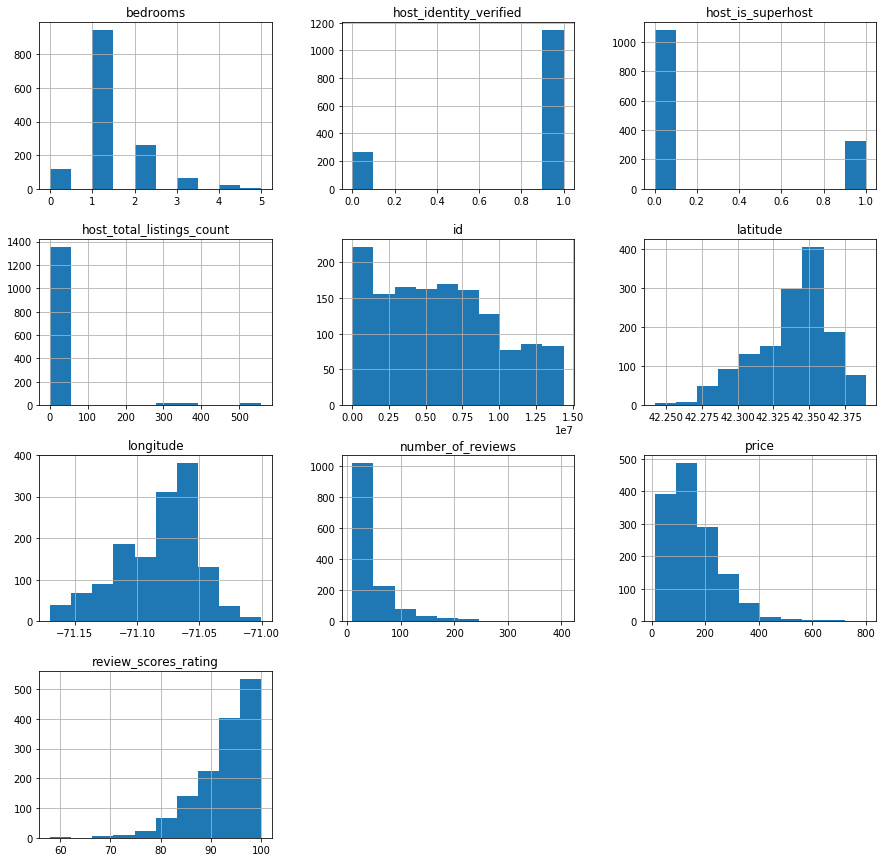

In [284]:
Subset_AirBnB_listing_df.hist(figsize=(15,15));

In [285]:
Subset_AirBnB_listing_df = pd.concat(
    [Subset_AirBnB_listing_df, pd.get_dummies(Subset_AirBnB_listing_df['property_type']), 
                                      pd.get_dummies(Subset_AirBnB_listing_df['room_type']), 
     pd.get_dummies(Subset_AirBnB_listing_df['neighbourhood_cleansed'])], axis = 1) 

In [286]:
Subset_AirBnB_listing_df

,id,last_scraped,host_is_superhost,host_total_listings_count,host_identity_verified,property_type,neighbourhood_cleansed,room_type,bedrooms,price,...,Mattapan,Mission Hill,North End,Roslindale,Roxbury,South Boston,South Boston Waterfront,South End,West End,West Roxbury
1,3075044,2016-09-07,0,1,1,Apartment,Roslindale,Private room,1.0,65.0,...,0,0,0,1,0,0,0,0,0,0
2,6976,2016-09-07,1,1,1,Apartment,Roslindale,Private room,1.0,65.0,...,0,0,0,1,0,0,0,0,0,0
4,7651065,2016-09-07,1,1,1,House,Roslindale,Private room,1.0,79.0,...,0,0,0,1,0,0,0,0,0,0
6,5706985,2016-09-07,0,5,1,Apartment,Roslindale,Entire home/apt,1.0,100.0,...,0,0,0,1,0,0,0,0,0,0
7,2843445,2016-09-07,1,2,1,House,Roslindale,Private room,1.0,75.0,...,0,0,0,1,0,0,0,0,0,0
8,753446,2016-09-07,1,1,1,Condominium,Roslindale,Private room,1.0,58.0,...,0,0,0,1,0,0,0,0,0,0
9,849408,2016-09-07,1,2,1,Apartment,Roslindale,Entire home/apt,2.0,229.0,...,0,0,0,1,0,0,0,0,0,0
11,1668313,2016-09-07,1,2,1,House,Roslindale,Private room,1.0,57.0,...,0,0,0,1,0,0,0,0,0,0
13,13547301,2016-09-07,0,1,1,Apartment,Roslindale,Entire home/apt,2.0,150.0,...,0,0,0,1,0,0,0,0,0,0
15,225979,2016-09-07,0,2,0,Apartment,Roslindale,Private room,1.0,60.0,...,0,0,0,1,0,0,0,0,0,0


In [287]:
AirBnB_reg_data = Subset_AirBnB_listing_df.drop(columns = ['id', 'last_scraped', 'property_type', 'room_type' , 'House', 'Entire home/apt' ,'latitude' , 'longitude', 'neighbourhood_cleansed', 'Roslindale'])

In [288]:
def compute_adjusted_r2(df, r2):
    '''
    INPUT
    df - pandas data frame in which adjusted r2 parameters are calculated based off of
    r2 - (float) percentage variation of the dependent variable explained by the explantory variables
    
    OUTPUT
    r2_adj - (float) adjust percentage variation to account for variables
    '''
    
    r2_adj = (1 - (1-r2)*(df.shape[0] - 1)/(df.shape[0] - (df.shape[1] - 1) -1))
                                          
    return r2_adj

In [289]:
# train-valid-test split
train, valid_test = train_test_split(AirBnB_reg_data, test_size=0.3,random_state=1)
valid, test = train_test_split(valid_test, test_size=0.5,random_state=1)

In [290]:
Y_train = train['price']
X_train = train.drop(columns=['price'])

Y_valid = valid['price']
X_valid = valid.drop(columns=['price'])

Y_test = test['price']
X_test = test.drop(columns=['price'])

### I. Linear Regression

In [301]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [292]:
Y_train_pred = lr_model.predict(X_train)
Y_valid_pred = lr_model.predict(X_valid)
Y_test_pred = lr_model.predict(X_test)

# Train error
train_mse = mean_squared_error(Y_train, Y_train_pred)
train_rmse = np.sqrt(mean_squared_error(Y_train, Y_train_pred))

# Valid error
valid_mse = mean_squared_error(Y_valid, Y_valid_pred)
valid_rmse = np.sqrt(mean_squared_error(Y_valid, Y_valid_pred))

# Test error
test_mse = mean_squared_error(Y_test, Y_test_pred)
test_rmse = np.sqrt(mean_squared_error(Y_test, Y_test_pred))

# Train r2 score
train_r2 = r2_score(Y_train, Y_train_pred)
train_adj_r2 = compute_adjusted_r2(AirBnB_reg_data, train_r2)

# Valid r2 score
valid_r2 = r2_score(Y_valid, Y_valid_pred)
valid_adj_r2 = compute_adjusted_r2(AirBnB_reg_data, valid_r2)

# Test r2 score
test_r2 = r2_score(Y_test, Y_test_pred)
test_adj_r2 = compute_adjusted_r2(AirBnB_reg_data, test_r2)

print("Train rmse: {:0.2f}; Valid rmse: {:0.2f}; Test rmse: {:0.2f}".format(train_rmse, valid_rmse, test_rmse))
print("Train r2 score: {:0.2f}; Valid r2 score: {:0.2f}; Test r2 score: {:0.2f}".format(train_r2, valid_r2, test_r2))
print("Train adj_r2 score: {:0.2f}; Valid adj_r2 score: {:0.2f}; Test adj_r2 score: {:0.2f}".format(train_adj_r2, valid_adj_r2, test_adj_r2))

Train rmse: 57.34; Valid rmse: 73.98; Test rmse: 62.04
Train r2 score: 0.68; Valid r2 score: 0.59; Test r2 score: 0.61
Train adj_r2 score: 0.67; Valid adj_r2 score: 0.58; Test adj_r2 score: 0.59


### II. Ridge Regression

In [293]:
# Ridge Regression
r_model = Ridge(alpha=20)
r_model.fit(X_train, Y_train)

Ridge(alpha=20, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [294]:
Y_train_pred = r_model.predict(X_train)
Y_valid_pred = r_model.predict(X_valid)
Y_test_pred = r_model.predict(X_test)

# Train error
train_mse = mean_squared_error(Y_train, Y_train_pred)
train_rmse = np.sqrt(mean_squared_error(Y_train, Y_train_pred))

# Valid error
valid_mse = mean_squared_error(Y_valid, Y_valid_pred)
valid_rmse = np.sqrt(mean_squared_error(Y_valid, Y_valid_pred))

# Test error
test_mse = mean_squared_error(Y_test, Y_test_pred)
test_rmse = np.sqrt(mean_squared_error(Y_test, Y_test_pred))

# Train r2 score
train_r2 = r2_score(Y_train, Y_train_pred)
train_adj_r2 = compute_adjusted_r2(AirBnB_reg_data, train_r2)

# Valid r2 score
valid_r2 = r2_score(Y_valid, Y_valid_pred)
valid_adj_r2 = compute_adjusted_r2(AirBnB_reg_data, valid_r2)

# Test r2 score
test_r2 = r2_score(Y_test, Y_test_pred)
test_adj_r2 = compute_adjusted_r2(AirBnB_reg_data, test_r2)

print("Train rmse: {:0.2f}; Valid rmse: {:0.2f}; Test rmse: {:0.2f}".format(train_rmse, valid_rmse, test_rmse))
print("Train r2 score: {:0.2f}; Valid r2 score: {:0.2f}; Test r2 score: {:0.2f}".format(train_r2, valid_r2, test_r2))
print("Train adj_r2 score: {:0.2f}; Valid adj_r2 score: {:0.2f}; Test adj_r2 score: {:0.2f}".format(train_adj_r2, valid_adj_r2, test_adj_r2))

Train rmse: 61.36; Valid rmse: 75.61; Test rmse: 59.80
Train r2 score: 0.64; Valid r2 score: 0.57; Test r2 score: 0.63
Train adj_r2 score: 0.63; Valid adj_r2 score: 0.56; Test adj_r2 score: 0.62


### III. Lasso Regression

In [295]:
l_model = Lasso(alpha=20)
l_model.fit(X_train, Y_train)

Lasso(alpha=20, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

In [296]:
Y_train_pred = l_model.predict(X_train)
Y_valid_pred = l_model.predict(X_valid)
Y_test_pred = l_model.predict(X_test)

# Train error
train_mse = mean_squared_error(Y_train, Y_train_pred)
train_rmse = np.sqrt(mean_squared_error(Y_train, Y_train_pred))

# Valid error
valid_mse = mean_squared_error(Y_valid, Y_valid_pred)
valid_rmse = np.sqrt(mean_squared_error(Y_valid, Y_valid_pred))

# Test error
test_mse = mean_squared_error(Y_test, Y_test_pred)
test_rmse = np.sqrt(mean_squared_error(Y_test, Y_test_pred))

# Train r2 score
train_r2 = r2_score(Y_train, Y_train_pred)
train_adj_r2 = compute_adjusted_r2(AirBnB_reg_data, train_r2)

# Valid r2 score
valid_r2 = r2_score(Y_valid, Y_valid_pred)
valid_adj_r2 = compute_adjusted_r2(AirBnB_reg_data, valid_r2)

# Test r2 score
test_r2 = r2_score(Y_test, Y_test_pred)
test_adj_r2 = compute_adjusted_r2(AirBnB_reg_data, test_r2)

print("Train rmse: {:0.2f}; Valid rmse: {:0.2f}; Test rmse: {:0.2f}".format(train_rmse, valid_rmse, test_rmse))
print("Train r2 score: {:0.2f}; Valid r2 score: {:0.2f}; Test r2 score: {:0.2f}".format(train_r2, valid_r2, test_r2))
print("Train adj_r2 score: {:0.2f}; Valid adj_r2 score: {:0.2f}; Test adj_r2 score: {:0.2f}".format(train_adj_r2, valid_adj_r2, test_adj_r2))

Train rmse: 82.01; Valid rmse: 97.49; Test rmse: 81.39
Train r2 score: 0.35; Valid r2 score: 0.29; Test r2 score: 0.32
Train adj_r2 score: 0.33; Valid adj_r2 score: 0.26; Test adj_r2 score: 0.30


### IV. XG Boost

In [297]:
params = {'eta': 0.35,\
          'max_depth': 6,\
          'min_child_weight': 30,\
          'objective': 'reg:linear',\
          'eval_metric': 'rmse',\
          'seed': 3,\
          'gamma':1,\
          'silent': True}

In [298]:
watchlist = [
    (xgb.DMatrix(X_train, Y_train), 'train'),
    (xgb.DMatrix(X_valid, Y_valid), 'validation'),
]
xgb_model = xgb.train(params, xgb.DMatrix(X_train, Y_train), 500,  watchlist, maximize=False,\
                      verbose_eval=5, early_stopping_rounds=50)

[0]	train-rmse:133.74	validation-rmse:150.308
Multiple eval metrics have been passed: 'validation-rmse' will be used for early stopping.

Will train until validation-rmse hasn't improved in 50 rounds.
[5]	train-rmse:65.1842	validation-rmse:83.7099
[10]	train-rmse:60.0103	validation-rmse:80.73
[15]	train-rmse:57.1157	validation-rmse:79.3358
[20]	train-rmse:55.5137	validation-rmse:79.0416
[25]	train-rmse:53.5966	validation-rmse:78.8218


/Users/billietong/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/billietong/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[30]	train-rmse:52.2657	validation-rmse:78.4282
[35]	train-rmse:51.0582	validation-rmse:78.6654
[40]	train-rmse:50.5016	validation-rmse:78.7966
[45]	train-rmse:49.7551	validation-rmse:78.6808
[50]	train-rmse:48.6578	validation-rmse:78.8524
[55]	train-rmse:47.2847	validation-rmse:78.4712
[60]	train-rmse:46.4185	validation-rmse:78.2035
[65]	train-rmse:45.5661	validation-rmse:78.7465
[70]	train-rmse:44.8865	validation-rmse:78.8635
[75]	train-rmse:44.2898	validation-rmse:79.1905
[80]	train-rmse:43.8158	validation-rmse:79.0044
[85]	train-rmse:43.1838	validation-rmse:79.1712
[90]	train-rmse:42.8441	validation-rmse:78.9846
[95]	train-rmse:42.1667	validation-rmse:79.2361
[100]	train-rmse:41.5674	validation-rmse:79.7432
[105]	train-rmse:41.1616	validation-rmse:80.0206
[110]	train-rmse:40.5889	validation-rmse:80.044
Stopping. Best iteration:
[62]	train-rmse:46.1328	validation-rmse:78.1877



In [299]:
Y_test_pred = xgb_model.predict(xgb.DMatrix(X_test), ntree_limit=xgb_model.best_ntree_limit)

# Test error
test_mse = mean_squared_error(Y_test, Y_test_pred)
test_rmse = np.sqrt(mean_squared_error(Y_test, Y_test_pred))

# Test r2 score
test_r2 = r2_score(Y_test, Y_test_pred)

# Test adj_r2 score
test_adj_r2 = compute_adjusted_r2(AirBnB_reg_data, test_r2)

print(test_rmse)
print(test_r2)
print(test_adj_r2)

66.68651372891442
0.5454763027710463
0.5318439168263593


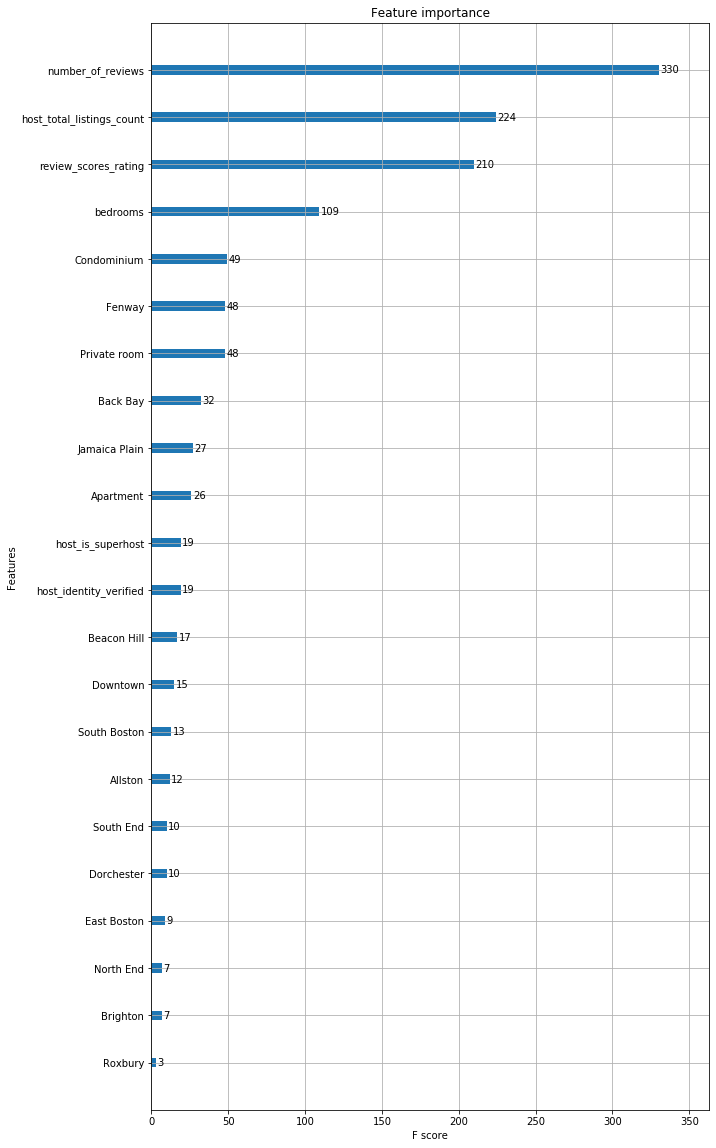

In [300]:
fig, ax = pyplot.subplots(figsize=(10,20));
xgb.plot_importance(xgb_model,ax=ax);

### Findings:

Based on the regression results, a large portion of the variation can be explained by the subset of listing characteristics. The ridge regression model was able to capture the greatest variation in price. 

### <a class="anchor" id="PartII">Objective III : Variations of Boston AirBnb rental prices part II</a>

In [207]:
#Subset Cleaned crime dataframe to include only crimes that happened within the last year of AirBnB data being scraped
Crime_Clean_df_09_16_2016 = subset_df(Crime_Clean_df, OCCURRED_ON_DATE_START = '2015-09-07', OCCURRED_ON_DATE_END= '2016-09-07')

In [208]:
Crime_Clean_df_09_16_2016.shape

(19003, 17)

In [211]:
#Create a column that counts the major crime occurences within ~5 kilometer radius of each listing
def create_major_crime_count(df1, df2):
    '''
    INPUT
    df1 - pandas data frame containing AirBnB listings in Boston
    df2 - pandas data frame containing Major Crime frequency data in Boston
    
    OUTPUT
    returns columns with counts of major crime occurences
    '''
    major_crime = []
    
    for index, row in df1.iterrows():
        count = 0
        for ind, rw in df2.iterrows():
            if (abs(row['latitude'] - rw['Lat']) + (82.3/111)*abs(row['longitude'] - rw['Long'])) < 0.05:
                count += 1
            else:
                count +=0
        major_crime.append(count)
        
    return major_crime

In [212]:
AirBnB_reg_data2 = AirBnB_reg_data
AirBnB_reg_data2['major_crime'] = create_major_crime_count(Subset_AirBnB_listing_df,Crime_Clean_df_09_16_2016)
AirBnB_reg_data2

,host_is_superhost,host_total_listings_count,host_identity_verified,bedrooms,price,review_scores_rating,number_of_reviews,Apartment,Bed & Breakfast,Boat,...,Mattapan,Mission Hill,North End,Roxbury,South Boston,South Boston Waterfront,South End,West End,West Roxbury,major_crime
1,0,1,1,1.0,65.0,94.0,36,1,0,0,...,0,0,0,0,0,0,0,0,0,3169
2,1,1,1,1.0,65.0,98.0,41,1,0,0,...,0,0,0,0,0,0,0,0,0,3192
4,1,1,1,1.0,79.0,99.0,29,0,0,0,...,0,0,0,0,0,0,0,0,0,2928
6,0,5,1,1.0,100.0,90.0,57,1,0,0,...,0,0,0,0,0,0,0,0,0,3155
7,1,2,1,1.0,75.0,96.0,67,0,0,0,...,0,0,0,0,0,0,0,0,0,2496
8,1,1,1,1.0,58.0,96.0,65,0,0,0,...,0,0,0,0,0,0,0,0,0,4192
9,1,2,1,2.0,229.0,94.0,33,1,0,0,...,0,0,0,0,0,0,0,0,0,2623
11,1,2,1,1.0,57.0,94.0,17,0,0,0,...,0,0,0,0,0,0,0,0,0,3022
13,0,1,1,2.0,150.0,97.0,12,1,0,0,...,0,0,0,0,0,0,0,0,0,3762
15,0,2,0,1.0,60.0,96.0,70,1,0,0,...,0,0,0,0,0,0,0,0,0,3304


### I. Linear Regression

In [238]:
# train-valid-test split
train, valid_test = train_test_split(AirBnB_reg_data2, test_size=0.3,random_state=1)
valid, test = train_test_split(valid_test, test_size=0.5,random_state=1)

In [239]:
Y_train = train['price']
X_train = train.drop(columns=['price'])

Y_valid = valid['price']
X_valid = valid.drop(columns=['price'])

Y_test = test['price']
X_test = test.drop(columns=['price'])

In [240]:
lr_model = LinearRegression()
lr_model.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [249]:
Y_train_pred = lr_model.predict(X_train)
Y_valid_pred = lr_model.predict(X_valid)
Y_test_pred = lr_model.predict(X_test)

# Train error
train_mse = mean_squared_error(Y_train, Y_train_pred)
train_rmse = np.sqrt(mean_squared_error(Y_train, Y_train_pred))

# Valid error
valid_mse = mean_squared_error(Y_valid, Y_valid_pred)
valid_rmse = np.sqrt(mean_squared_error(Y_valid, Y_valid_pred))

# Test error
test_mse = mean_squared_error(Y_test, Y_test_pred)
test_rmse = np.sqrt(mean_squared_error(Y_test, Y_test_pred))

# Train r2 score
train_r2 = r2_score(Y_train, Y_train_pred)
train_adj_r2 = compute_adjusted_r2(AirBnB_reg_data2, train_r2)

# Valid r2 score
valid_r2 = r2_score(Y_valid, Y_valid_pred)
valid_adj_r2 = compute_adjusted_r2(AirBnB_reg_data2, valid_r2)

# Test r2 score
test_r2 = r2_score(Y_test, Y_test_pred)
test_adj_r2 = compute_adjusted_r2(AirBnB_reg_data2, test_r2)

print("Train rmse: {:0.2f}; Valid rmse: {:0.2f}; Test rmse: {:0.2f}".format(train_rmse, valid_rmse, test_rmse))
print("Train r2 score: {:0.2f}; Valid r2 score: {:0.2f}; Test r2 score: {:0.2f}".format(train_r2, valid_r2, test_r2))
print("Train adj_r2 score: {:0.2f}; Valid adj_r2 score: {:0.2f}; Test adj_r2 score: {:0.2f}".format(train_adj_r2, valid_adj_r2, test_adj_r2))

Train rmse: 57.34; Valid rmse: 73.98; Test rmse: 62.04
Train r2 score: 0.68; Valid r2 score: 0.59; Test r2 score: 0.61
Train adj_r2 score: 0.67; Valid adj_r2 score: 0.58; Test adj_r2 score: 0.59


### II. Ridge Regression

In [242]:
# Ridge Regression
r_model = Ridge(alpha=20)
r_model.fit(X_train, Y_train)

Ridge(alpha=20, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [250]:
Y_train_pred = r_model.predict(X_train)
Y_valid_pred = r_model.predict(X_valid)
Y_test_pred = r_model.predict(X_test)

# Train error
train_mse = mean_squared_error(Y_train, Y_train_pred)
train_rmse = np.sqrt(mean_squared_error(Y_train, Y_train_pred))

# Valid error
valid_mse = mean_squared_error(Y_valid, Y_valid_pred)
valid_rmse = np.sqrt(mean_squared_error(Y_valid, Y_valid_pred))

# Test error
test_mse = mean_squared_error(Y_test, Y_test_pred)
test_rmse = np.sqrt(mean_squared_error(Y_test, Y_test_pred))

# Train r2 score
train_r2 = r2_score(Y_train, Y_train_pred)
train_adj_r2 = compute_adjusted_r2(AirBnB_reg_data2, train_r2)

# Valid r2 score
valid_r2 = r2_score(Y_valid, Y_valid_pred)
valid_adj_r2 = compute_adjusted_r2(AirBnB_reg_data2, valid_r2)

# Test r2 score
test_r2 = r2_score(Y_test, Y_test_pred)
test_adj_r2 = compute_adjusted_r2(AirBnB_reg_data2, test_r2)

print("Train rmse: {:0.2f}; Valid rmse: {:0.2f}; Test rmse: {:0.2f}".format(train_rmse, valid_rmse, test_rmse))
print("Train r2 score: {:0.2f}; Valid r2 score: {:0.2f}; Test r2 score: {:0.2f}".format(train_r2, valid_r2, test_r2))
print("Train adj_r2 score: {:0.2f}; Valid adj_r2 score: {:0.2f}; Test adj_r2 score: {:0.2f}".format(train_adj_r2, valid_adj_r2, test_adj_r2))

Train rmse: 60.61; Valid rmse: 74.91; Test rmse: 59.90
Train r2 score: 0.65; Valid r2 score: 0.58; Test r2 score: 0.63
Train adj_r2 score: 0.63; Valid adj_r2 score: 0.57; Test adj_r2 score: 0.62


### III. Lasso Regression

In [244]:
l_model = Lasso(alpha=20)
l_model.fit(X_train, Y_train)

Lasso(alpha=20, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

In [251]:
Y_train_pred = l_model.predict(X_train)
Y_valid_pred = l_model.predict(X_valid)
Y_test_pred = l_model.predict(X_test)

# Train error
train_mse = mean_squared_error(Y_train, Y_train_pred)
train_rmse = np.sqrt(mean_squared_error(Y_train, Y_train_pred))

# Valid error
valid_mse = mean_squared_error(Y_valid, Y_valid_pred)
valid_rmse = np.sqrt(mean_squared_error(Y_valid, Y_valid_pred))

# Test error
test_mse = mean_squared_error(Y_test, Y_test_pred)
test_rmse = np.sqrt(mean_squared_error(Y_test, Y_test_pred))

# Train r2 score
train_r2 = r2_score(Y_train, Y_train_pred)
train_adj_r2 = compute_adjusted_r2(AirBnB_reg_data2, train_r2)

# Valid r2 score
valid_r2 = r2_score(Y_valid, Y_valid_pred)
valid_adj_r2 = compute_adjusted_r2(AirBnB_reg_data2, valid_r2)

# Test r2 score
test_r2 = r2_score(Y_test, Y_test_pred)
test_adj_r2 = compute_adjusted_r2(AirBnB_reg_data2, test_r2)

print("Train rmse: {:0.2f}; Valid rmse: {:0.2f}; Test rmse: {:0.2f}".format(train_rmse, valid_rmse, test_rmse))
print("Train r2 score: {:0.2f}; Valid r2 score: {:0.2f}; Test r2 score: {:0.2f}".format(train_r2, valid_r2, test_r2))
print("Train adj_r2 score: {:0.2f}; Valid adj_r2 score: {:0.2f}; Test adj_r2 score: {:0.2f}".format(train_adj_r2, valid_adj_r2, test_adj_r2))

Train rmse: 79.74; Valid rmse: 95.23; Test rmse: 79.52
Train r2 score: 0.39; Valid r2 score: 0.32; Test r2 score: 0.35
Train adj_r2 score: 0.37; Valid adj_r2 score: 0.30; Test adj_r2 score: 0.33


### IV. XG Boost

In [252]:
params = {'eta': 0.35,\
          'max_depth': 6,\
          'min_child_weight': 30,\
          'objective': 'reg:linear',\
          'eval_metric': 'rmse',\
          'seed': 3,\
          'gamma':1,\
          'silent': True}

In [253]:
watchlist = [
    (xgb.DMatrix(X_train, Y_train), 'train'),
    (xgb.DMatrix(X_valid, Y_valid), 'validation'),
]
xgb_model = xgb.train(params, xgb.DMatrix(X_train, Y_train), 500,  watchlist, maximize=False,\
                      verbose_eval=5, early_stopping_rounds=50)

[0]	train-rmse:132.847	validation-rmse:148.061
Multiple eval metrics have been passed: 'validation-rmse' will be used for early stopping.

Will train until validation-rmse hasn't improved in 50 rounds.
[5]	train-rmse:60.2164	validation-rmse:78.1931
[10]	train-rmse:55.3345	validation-rmse:75.8501
[15]	train-rmse:51.9602	validation-rmse:75.0734
[20]	train-rmse:49.383	validation-rmse:75.98
[25]	train-rmse:47.9305	validation-rmse:75.8298


/Users/billietong/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/billietong/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[30]	train-rmse:45.961	validation-rmse:75.9574
[35]	train-rmse:44.7699	validation-rmse:75.4106
[40]	train-rmse:43.3426	validation-rmse:75.0899
[45]	train-rmse:41.9178	validation-rmse:75.7015
[50]	train-rmse:40.702	validation-rmse:75.9649
[55]	train-rmse:39.3776	validation-rmse:76.1892
[60]	train-rmse:38.4762	validation-rmse:76.6184
[65]	train-rmse:37.7493	validation-rmse:76.2194
[70]	train-rmse:37.1127	validation-rmse:76.4483
[75]	train-rmse:36.3575	validation-rmse:76.5463
[80]	train-rmse:35.5821	validation-rmse:76.9637
[85]	train-rmse:35.013	validation-rmse:77.0429
Stopping. Best iteration:
[37]	train-rmse:44.022	validation-rmse:74.8941



In [255]:
Y_test_pred = xgb_model.predict(xgb.DMatrix(X_test), ntree_limit=xgb_model.best_ntree_limit)

# Test error
test_mse = mean_squared_error(Y_test, Y_test_pred)
test_rmse = np.sqrt(mean_squared_error(Y_test, Y_test_pred))

# Test r2 score
test_r2 = r2_score(Y_test, Y_test_pred)

# Test adj_r2 score
test_adj_r2 = compute_adjusted_r2(AirBnB_reg_data2, test_r2)

print(test_rmse)
print(test_r2)
print(test_adj_r2)

67.83585526621565
0.5296738641388051
0.5152128848517112


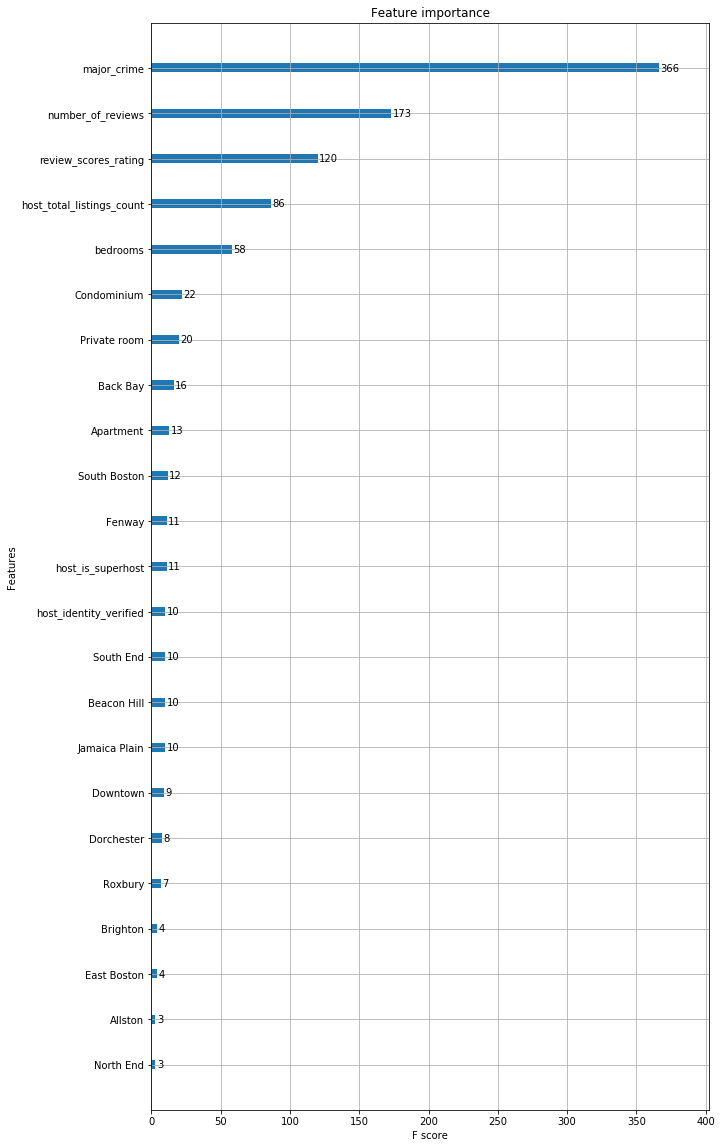

In [256]:
fig, ax = pyplot.subplots(figsize=(10,20));
xgb.plot_importance(xgb_model,ax=ax);

### Findings:

Crime frequency within a ~5km radius of each listing does not have practical significance in improving the percentage of variation of Airbnb listing prices explained by the subset of listing characteristics. This may be because renters are not aware of crime frequency associated with each listing above what is known through neighborhood associations.

## References

1. Boston Crimes Dataset retrieved from: https://www.kaggle.com/AnalyzeBoston/crimes-in-boston, on September 12, 2019
2. Boston Airbnb Dataset retrieved from: https://www.kaggle.com/airbnb/boston, on September 14, 2019
3. UCR Offenses retrieved from: https://ucr.fbi.gov/crime-in-the-u.s/2011/crime-in-the-u.s.-2011/offense-definitions, on September 14, 2019

## Appendix: 

### UCR Offenses Part I:

Forcible rape―The carnal knowledge of a female forcibly and against her will.  Rapes by force and attempts or assaults to rape, regardless of the age of the victim, are included.  Statutory offenses (no force used―victim under age of consent) are excluded.

Robbery―The taking or attempting to take anything of value from the care, custody, or control of a person or persons by force or threat of force or violence and/or by putting the victim in fear.

Aggravated assault―An unlawful attack by one person upon another for the purpose of inflicting severe or aggravated bodily injury.  This type of assault usually is accompanied by the use of a weapon or by means likely to produce death or great bodily harm.  Simple assaults are excluded.

Burglary (breaking or entering)―The unlawful entry of a structure to commit a felony or a theft.  Attempted forcible entry is included.

Larceny-theft (except motor vehicle theft)―The unlawful taking, carrying, leading, or riding away of property from the possession or constructive possession of another.  Examples are thefts of bicycles, motor vehicle parts and accessories, shoplifting, pocket-picking, or the stealing of any property or article that is not taken by force and violence or by fraud.  Attempted larcenies are included.  Embezzlement, confidence games, forgery, check fraud, etc., are excluded.

Motor vehicle theft―The theft or attempted theft of a motor vehicle.  A motor vehicle is self-propelled and runs on land surface and not on rails.  Motorboats, construction equipment, airplanes, and farming equipment are specifically excluded from this category.

Arson―Any willful or malicious burning or attempt to burn, with or without intent to defraud, a dwelling house, public building, motor vehicle or aircraft, personal property of another, etc.